In [49]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from econml.metalearners import SLearner, TLearner
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML, NonParamDML
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error 
import shap

Define Necessary Functions

In [50]:
#Split into train and test set
def get_split(simulation: pd.DataFrame) -> np.ndarray:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]].to_numpy()
    T_train = train_df['T'].to_numpy()
    Y_train = train_df['y'].to_numpy()

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]].to_numpy()
    T_test = test_df['T'].to_numpy()
    y_test = test_df['y'].to_numpy()

    true_cate_test = test_df['CATE'].to_numpy()

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test

In [51]:
def vis_treatment_eff(simulation: pd.DataFrame):
    sorted_cate = simulation[simulation['T'] == 1]
    sorted_cate = sorted_cate.sort_values(by=['CATE'])
    sorted_cate = sorted_cate[['CATE']]

    x = np.linspace(0, len(sorted_cate), num=len(sorted_cate))
    plt.scatter(x, sorted_cate, alpha=0.5)
    #plt.plot(x, sorted_cate, color='red')
    plt.xlabel('Observations')
    plt.ylabel('Treatment Effects')

In [52]:
def plot_predict_cate_corr(est_cate: np.array, true_cate_test: np.array):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(est_cate, true_cate_test, alpha=0.5)    
    plt.plot([min(true_cate_test), max(true_cate_test)], [min(true_cate_test), max(true_cate_test)], '--', color='red')
    plt.xlabel('Estimated CATE')
    plt.ylabel('True CATE')
    plt.grid(True)
    plt.show()

    est_cate=est_cate.reshape(-1, 1)
    reg = LinearRegression().fit(est_cate, true_cate_test)
    print(f'Correlation between true and predicted CATE: {reg.score(est_cate, true_cate_test)}')

Create Simulations

In [72]:
#Create simulations

sim_dict = {}
i = 1

for p in [10, 20, 30, 50]:
    for n in [5000, 7000, 10000]:
        sim: SimulationStudy = SimulationStudy(p=p, mean_correlation=0.5, cor_variance=0.1, n=n)
        simulation = sim.create_dataset()


        key = f'Simulation_{p}_{n}'
        value = simulation

        sim_dict[key]= value
        i += 1


Correlation structure has to be adjusted
Correlation structure has to be adjusted
Correlation structure has to be adjusted
Correlation structure has to be adjusted
Correlation structure has to be adjusted
Correlation structure has to be adjusted
Correlation structure has to be adjusted


covariance is not symmetric positive-semidefinite.
covariance is not symmetric positive-semidefinite.
covariance is not symmetric positive-semidefinite.
covariance is not symmetric positive-semidefinite.
covariance is not symmetric positive-semidefinite.
covariance is not symmetric positive-semidefinite.
covariance is not symmetric positive-semidefinite.


Correlation structure has to be adjusted
Correlation structure has to be adjusted


covariance is not symmetric positive-semidefinite.
covariance is not symmetric positive-semidefinite.


In [73]:
#Split df into train and test data

splits_dict = {}

for key, value in sim_dict.items():

    train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test = get_split(value)
    
    temp_dict = {'train_df': train_df, 'test_df': test_df, 
                   'X_train': X_train, 'Y_train': Y_train, 
                   'T_train': T_train, 'X_test': X_test, 
                   'T_test': T_test, 'y_test': y_test, 
                   'true_cate_test': true_cate_test}

        
    splits_dict[key] = temp_dict



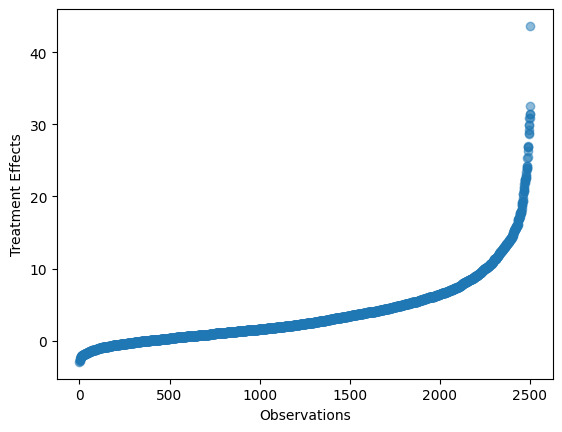

In [64]:
#Visualize Treatment Effects for ordered observations
vis_treatment_eff(sim_dict['Simulation_10_5000'])

OLS Model

In [26]:
#Create OLS model
ols = LinearRegression()

In [35]:
#Estimate a fully feature-treatment interacted model

X_train = pd.DataFrame(splits_dict['Simulation_10_10000']['X_train'])
print(X_train.shape)

for col in X_train.columns:
    print(col)
    X_train['interaction'] = X_train[col]*splits_dict['Simulation_10_10000']['T_train']
    
X_train = X_train.to_numpy()
print(X_train.shape)

(5000, 10)
0
1
2
3
4
5
6
7
8
9
(5000, 10)


In [34]:
X_train

array([[-0.        , -0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.35198106, -1.05884359, -0.65618787, ..., -1.4227258 ,
        -0.64358055,  0.58714677],
       ...,
       [ 0.62977001, -1.02374574, -0.51376727, ..., -1.93194205,
        -0.99632546,  0.2844335 ],
       [ 0.95499248, -0.6268611 , -0.23242512, ..., -0.95945654,
         0.23528105,  0.14437381],
       [ 1.46982312,  0.94941436,  2.27224406, ...,  1.51744112,
         1.64359719,  0.90228816]])

In [ ]:
interaction_terms = splits_dict['Simulation_10_10000']['X_train'] * splits_dict['Simulation_10_10000']['T_train']

In [ ]:
interaction_terms = splits_dict['Simulation_10_10000']['X_train'] * splits_dict['Simulation_10_10000']['T_train']
X_train_ols = np.hstack([splits_dict['Simulation_10_10000']['X_train'], splits_dict['Simulation_10_10000']['T_train'], X_train])
ols.fit(X_train_ols, splits_dict['Simulation_10_10000']['y_train'])

In [ ]:
interaction_term_test = splits_dict['Simulation_10_10000']['X_test'] * splits_dict['Simulation_10_10000']['T_test']
X_test_ols = np.hstack([splits_dict['Simulation_10_10000']['X_test'], splits_dict['Simulation_10_10000']['T_test'], interaction_term_test])
est_error = (splits_dict['Simulation_10_10000']['y_test'] - ols.predict(X_test_ols))**2

In [322]:
#Cannot currently estimate CATE functions from OLS to compare with true CATEs
#Treatment and control groups have different sizes

interaction_term_test = X_test_1 * T_test_1
X_test_ols = np.hstack([X_test_1, T_test_1, interaction_term_test])

treatment_col_index = sim_1.p

# Generate treatment and control groups
treatment_group = X_test_ols[X_test_ols[:, treatment_col_index] == 1]
control_group = X_test_ols[X_test_ols[:, treatment_col_index] == 0]

# Predict outcomes
pred_treatment = ols.predict(treatment_group)
pred_control = ols.predict(control_group)

In [323]:
#plt.figure(figsize=(8, 8))
#plt.scatter(est_error, true_cate_test_1, alpha=0.5, label='OLS')
#plt.plot([min(true_cate_test_1), max(true_cate_test_1)], [min(true_cate_test_1), max(true_cate_test_1)], '--', color='red')
#plt.xlabel('OLS MSE')
#plt.ylabel('True CATE')
#plt.title('Estimated vs. True CATE')
#plt.legend()
#plt.grid(True)
#plt.show()

In [324]:
#estimated_cate_ols=estimated_cate_ols.reshape(-1, 1)
#true_cate_test=true_cate_test_1.reshape(-1,1)
#reg = LinearRegression().fit(estimated_cate_ols, true_cate_test)
#reg.score(estimated_cate_ols, true_cate_test)

S-Learner

In [325]:
#s_learner = SLearner(overall_model=RandomForestRegressor())  
#s_learner_model = s_learner.fit(Y=Y_train_1, T=T_train_1, X=X_train_1)
#pred_cate_s = s_learner_model.effect(X_test_1)
#plot_predict_cate_corr(pred_cate_s, true_cate_test_1)

T-Learner

In [74]:
def TLearner_estimator(Y_train, T_train, X_train, X_test, true_cate_test):

    est_t = TLearner(models=RandomForestRegressor())
    est_t.fit(Y=Y_train, T=T_train, X=X_train)
    estimated_cate_t = est_t.effect(X_test)
    T_MSE = mean_squared_error(true_cate_test, estimated_cate_t)

    return estimated_cate_t, T_MSE

estimated_cate_t, T_MSE = TLearner_estimator(splits_dict['Simulation_10_5000']['Y_train'], splits_dict['Simulation_10_5000']['T_train'], 
                                             splits_dict['Simulation_10_5000']['X_train'], splits_dict['Simulation_10_5000']['X_test'],
                                             splits_dict['Simulation_10_5000']['true_cate_test'])



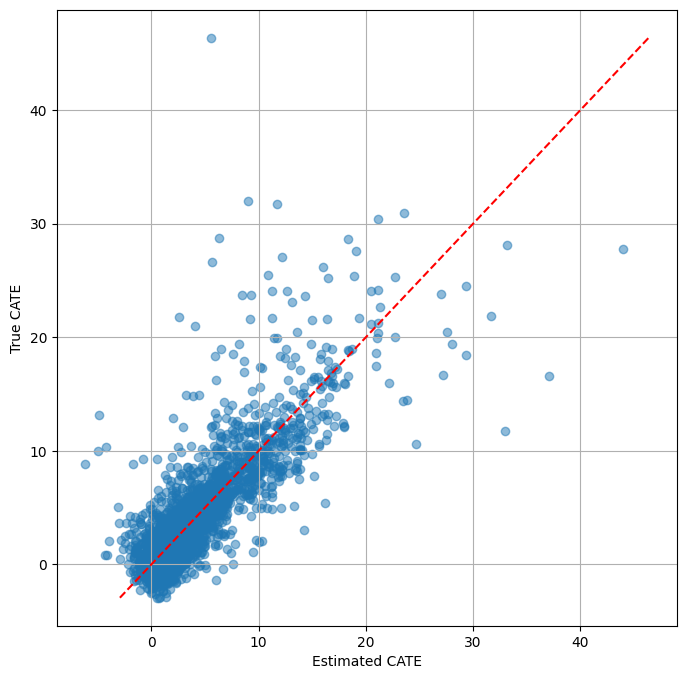

Correlation between true and predicted CATE: 0.6586166177711003


In [75]:
plot_predict_cate_corr(estimated_cate_t, splits_dict['Simulation_10_5000']['true_cate_test'])

Causal Forest DML

In [76]:
def CF_DML(Y_train, T_train, X_train, X_test, true_cate_test):

#Estimate the causal forest model
    est_cfdml = CausalForestDML(model_y='auto',
                        model_t=DummyClassifier(),
                        discrete_treatment=True,
                        cv=5,
                        n_estimators=1000,
                        random_state=42,
                        criterion='mse',
                        honest=True)

    est_cfdml.fit(Y=Y_train, T=T_train, X=X_train, W=None, cache_values=True)
    estimated_cate = est_cfdml.effect(X_test)
    mse = mean_squared_error(true_cate_test, estimated_cate)
    
    return estimated_cate, mse

estimated_cate_dml, cf_dml_MSE = CF_DML(splits_dict['Simulation_10_5000']['Y_train'], splits_dict['Simulation_10_5000']['T_train'], 
                                       splits_dict['Simulation_10_5000']['X_train'], splits_dict['Simulation_10_5000']['X_test'],
                                       splits_dict['Simulation_10_5000']['true_cate_test'])



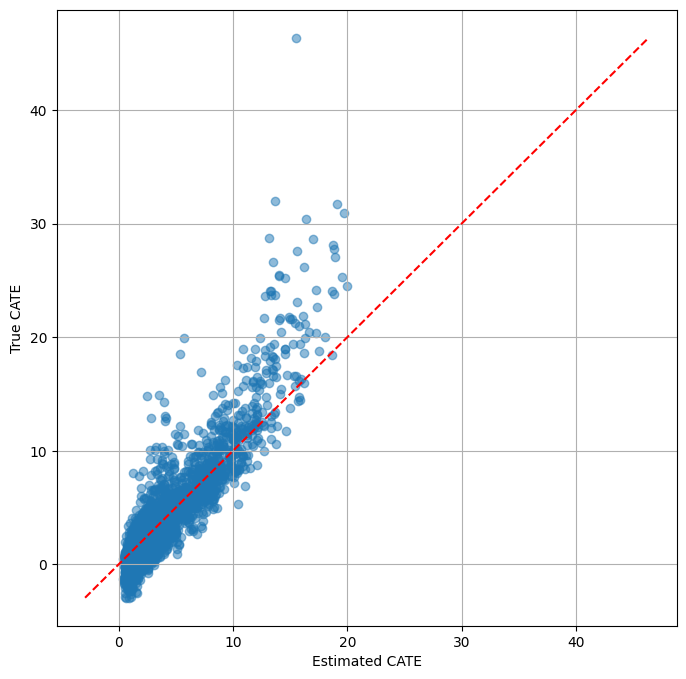

Correlation between true and predicted CATE: 0.8219044759495819


In [77]:
plot_predict_cate_corr(estimated_cate_dml, splits_dict['Simulation_10_5000']['true_cate_test'])

Non-Parametric DML

In [78]:
def non_param_dml(Y_train, T_train, X_train, X_test, true_cate_test):

    est_npm = NonParamDML(
        model_y='auto',
        model_t=DummyClassifier(),
        model_final=GradientBoostingRegressor(),
        cv = 5,
        random_state = 42,
        discrete_treatment=True,
    )
    
    est_npm.fit(Y=Y_train, T=T_train, X=X_train, W=None, cache_values=True)
    estimated_cate = est_npm.effect(X_test)
    mse = mean_squared_error(true_cate_test, estimated_cate)

    return estimated_cate, mse

estimated_cate_non_param, non_param_MSE = non_param_dml(splits_dict['Simulation_10_5000']['Y_train'], splits_dict['Simulation_10_5000']['T_train'], 
                                       splits_dict['Simulation_10_5000']['X_train'], splits_dict['Simulation_10_5000']['X_test'],
                                       splits_dict['Simulation_10_5000']['true_cate_test'])



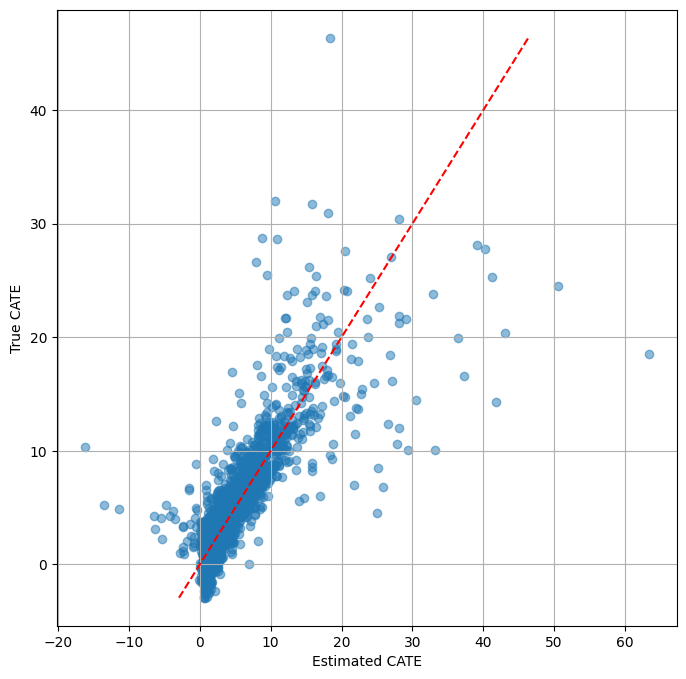

Correlation between true and predicted CATE: 0.6722304483735916


In [79]:
plot_predict_cate_corr(estimated_cate_non_param, splits_dict['Simulation_10_5000']['true_cate_test'])

In [80]:
print(f'MSE T-Learner: {T_MSE}')
print(f'MSE Double ML: {cf_dml_MSE}')
print(f'MSE Non-Parametric Double ML: {non_param_MSE}')

MSE T-Learner: 8.89734039279279
MSE Double ML: 5.260032201578938
MSE Non-Parametric Double ML: 9.436755809449856
